<a href="https://colab.research.google.com/github/Aruna-Jayarajan/Satelite_Network/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
from src.data_loader import load_all_data
from src.graph_builder import build_full_graph
from src.model import SatGatewayGNN
from src.train_single import train_until_converged
from src.utils import top_k_accuracy, gateway_coverage_metric, satellite_coverage_metric

from torch_geometric.utils import from_networkx


Train single file

In [ ]:
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN
from src.train_single import train_until_converged

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Preview snapshot columns ===
selected_file = os.listdir(folder_path)[0]
snapshot_path = os.path.join(folder_path, selected_file)
print(f"\nColumns in snapshot file '{selected_file}':")
print(pd.read_csv(snapshot_path).columns.tolist())

# === Load snapshot ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file)

# === Build graph ===
data = build_hetero_graph(satellites, gateways, cells)

# === Normalize node features ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

data['sat'].x = normalize(data['sat'].x)
data['gateway'].x = normalize(data['gateway'].x)
data['cell'].x = normalize(data['cell'].x)

# === Extract stats ===
num_sats = data['sat'].num_nodes
num_gws = data['gateway'].num_nodes
num_cells = data['cell'].num_nodes

print(f"\nGraph has {num_sats} satellites, {num_gws} gateways, {num_cells} cells.")

# === Create auxiliary inputs ===

# Satellite → Gateway visibility
visibility_matrix = torch.zeros((num_sats, num_gws))
for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
    visibility_matrix[src, dst] = 1

# Satellite → Cell visibility (through gateways)
cell_visibility_matrix = torch.zeros((num_sats, num_cells))
for gw, cell in data['gateway', 'serves', 'cell'].edge_index.t():
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        if dst == gw:
            cell_visibility_matrix[src, cell] = 1

# Cell demands
cell_demands = data['cell'].x[:, -1].unsqueeze(1)  # Already normalized above

aux_inputs = {
    'visibility_matrix': visibility_matrix,
    'cell_visibility_matrix': cell_visibility_matrix,
    'cell_demands': cell_demands
}

print("\n=== Visibility Stats ===")
print("Avg visible gateways per satellite:", visibility_matrix.sum(dim=1).mean().item())
print("Max visible gateways per satellite:", visibility_matrix.sum(dim=1).max().item())
print("Avg visible cells per satellite:", cell_visibility_matrix.sum(dim=1).mean().item())
print("Max visible cells per satellite:", cell_visibility_matrix.sum(dim=1).max().item())

# === Model & optimizer ===
hidden_dim = 64
model = SatGatewayGNN(hidden_dim, num_gateways=num_gws, num_cells=num_cells)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# === Loss weights (tune as needed) ===
loss_weights = {
    'alpha': 3.0,  # Gateway coverage
    'beta': 1.0,   # Satellite-to-GW assignment normalization
    'gamma': 0.0,  # Demand fairness (OFF)
    'delta': 4.0,  # Cell coverage
    'zeta': 0.0    # Sat overcommit (OFF)
}

# === Train ===
trained_model, history = train_until_converged(
    model=model,
    data=data,
    optimizer=optimizer,
    aux_inputs=aux_inputs,
    loss_weights=loss_weights,
    epochs=200,
    patience=30
)

# === Plot results ===
plt.plot([x * 100 for x in history['gateway_coverage']], label='Gateway Coverage (%)')
plt.plot([x * 100 for x in history['cell_coverage']], label='Cell Coverage (%)')
plt.xlabel('Coordination Round')
plt.ylabel('Coverage (%)')
plt.title('Coverage over Coordination Rounds')
plt.legend()
plt.grid(True)
plt.show()


Loading and building graphs from top 10 snapshots...
- file_data_00_00_00.csv


TypeError: load_all_data() got an unexpected keyword argument 'snapshot_filename'

In [2]:
import pandas as pd

def summarize_satellite_assignments(model, data, aux_inputs, gateway_thresh=0.1, cell_thresh=0.1):
    model.eval()
    with torch.no_grad():
        gw_probs, cell_probs = model(data)

    visibility_matrix = aux_inputs['visibility_matrix']
    cell_visibility_matrix = aux_inputs['cell_visibility_matrix']

    summary = []

    for sat_idx in range(data['sat'].num_nodes):
        visible_gws = visibility_matrix[sat_idx] > 0
        selected_gws = (gw_probs[sat_idx] > gateway_thresh) & visible_gws
        gw_ids = torch.where(selected_gws)[0].tolist()

        visible_cells = cell_visibility_matrix[sat_idx] > 0
        selected_cells = (cell_probs[sat_idx] > cell_thresh) & visible_cells
        cell_ids = torch.where(selected_cells)[0].tolist()

        summary.append({
            'sat_id': sat_idx,
            'connected_gateways': gw_ids,
            'connected_cells': cell_ids
        })

    return pd.DataFrame(summary)

# === Create and save summary table ===
summary_df = summarize_satellite_assignments(trained_model, data, aux_inputs)
summary_df.to_csv("satellite_connectivity_summary.csv", index=False)
print("\n✅ Summary saved as 'satellite_connectivity_summary.csv'")
display(summary_df.head())



✅ Summary saved as 'satellite_connectivity_summary.csv'


,sat_id,connected_gateways,connected_cells
0,0,"[17, 22, 32, 47]","[0, 1, 7, 12, 13, 18, 21, 25, 29, 33, 38, 40, ..."
1,1,"[15, 16, 27, 53]","[3, 13, 20, 21, 24, 33, 37, 45, 54, 55, 60, 61..."
2,2,"[3, 8, 9, 39]","[14, 15, 23, 32, 35, 41, 42, 43, 58, 62, 64, 7..."
3,3,"[6, 30, 31, 33]","[3, 9, 10, 14, 15, 17, 59, 86, 175, 196, 208, ..."
4,4,"[17, 36]","[18, 25, 50, 51, 150, 155, 169, 180, 184, 216,..."


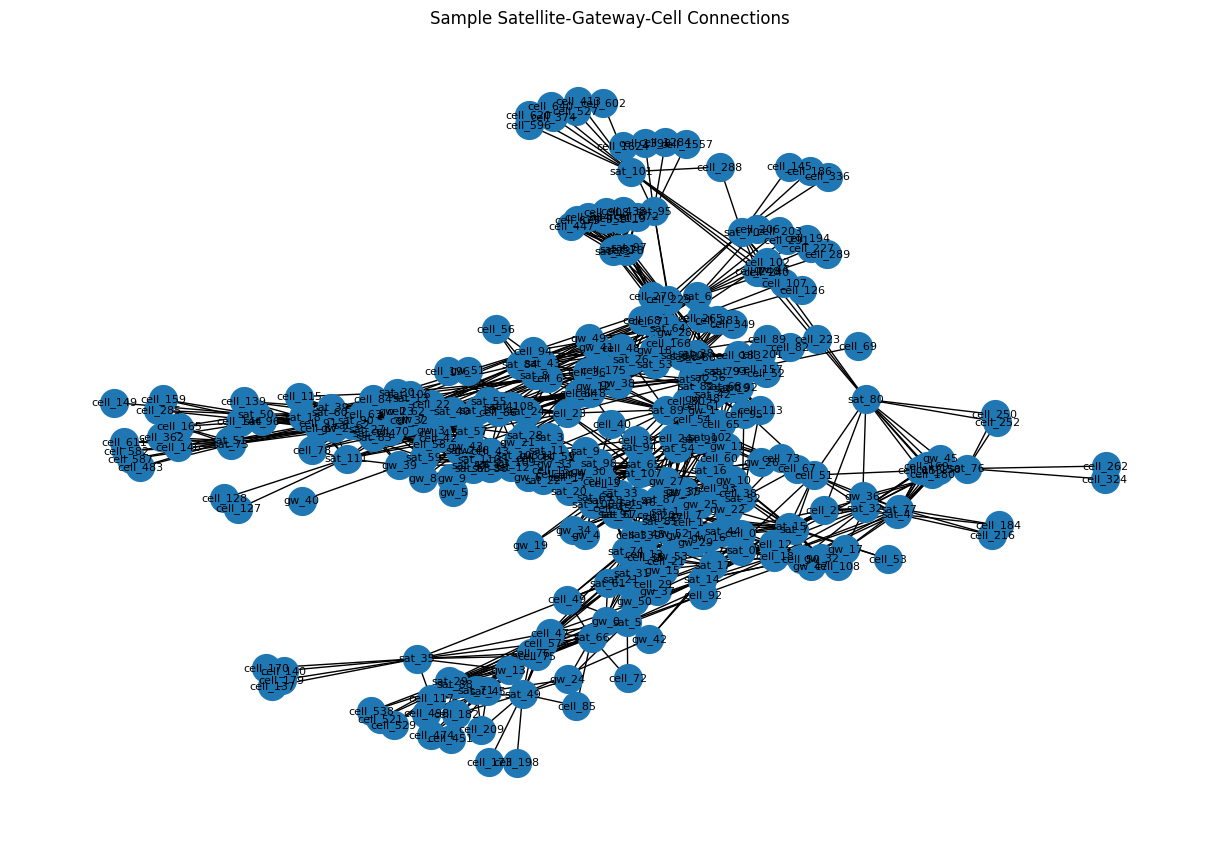

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for _, row in summary_df.iterrows():
    sat = f"sat_{row['sat_id']}"
    for gw in row['connected_gateways']:
        G.add_edge(sat, f"gw_{gw}")
    for cell in row['connected_cells'][:10]:  # show sample
        G.add_edge(sat, f"cell_{cell}")

plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_size=400, font_size=8)
plt.title("Sample Satellite-Gateway-Cell Connections")
plt.show()


In [8]:
import torch
import pandas as pd

# === Inference ===
model.eval()
with torch.no_grad():
    gateway_probs, cell_probs = model(data)  # Shape: [num_sats, num_gateways] and [num_sats, num_cells]

# === Uncovered Gateways ===
# Each satellite selects its best gateway
assigned_gateways = torch.argmax(gateway_probs, dim=1).tolist()

# Unique gateways that received at least one assignment
covered_gateways = set(assigned_gateways)

# All gateway IDs
all_gateways = set(range(data['gateway'].num_nodes))

# Gateways that were not assigned to any satellite
uncovered_gateways = sorted(list(all_gateways - covered_gateways))

# === Uncovered Cells ===
# If any satellite assigns some probability > threshold to a cell, consider it covered
threshold = 0.5
covered_cells = (cell_probs > threshold).any(dim=0).nonzero(as_tuple=True)[0].tolist()

all_cells = set(range(data['cell'].num_nodes))
uncovered_cells = sorted(list(all_cells - set(covered_cells)))

# === Save to CSV ===
pd.DataFrame({'uncovered_gateway_id': uncovered_gateways}).to_csv("uncovered_gateways.csv", index=False)
pd.DataFrame({'uncovered_cell_id': uncovered_cells}).to_csv("uncovered_cells.csv", index=False)

# Optional: print some stats
print(f"Uncovered Gateways: {len(uncovered_gateways)} out of {len(all_gateways)}")
print(f"Uncovered Cells: {len(uncovered_cells)} out of {len(all_cells)}")


Uncovered Gateways: 15 out of 54
Uncovered Cells: 213 out of 4569


In [5]:
torch.save(model.state_dict(), "trained_sat_gateway_model.pt")


Test on another file

In [9]:
import torch
import os
import pandas as pd
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Pick the 2nd snapshot file ===
snapshot_files = sorted(os.listdir(folder_path))
selected_file = snapshot_files[1]  # second file
snapshot_path = os.path.join(folder_path, selected_file)

# === Show snapshot columns ===
print(f"\nColumns in snapshot file '{selected_file}':")
print(pd.read_csv(snapshot_path).columns.tolist())

# === Load the snapshot ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file)

# === Rebuild the graph ===
data = build_hetero_graph(satellites, gateways, cells)

# === Reload trained model ===
model = SatGatewayGNN(hidden_dim=64, num_gateways=data['gateway'].num_nodes, num_cells=data['cell'].num_nodes)
model.load_state_dict(torch.load("trained_sat_gateway_model.pt"))
model.eval()

# === Inference ===
with torch.no_grad():
    gateway_probs, cell_probs = model(data)

# === Coverage Analysis ===
# Gateways
assigned_gateways = torch.argmax(gateway_probs, dim=1).tolist()
covered_gateways = set(assigned_gateways)
all_gateways = set(range(data['gateway'].num_nodes))
uncovered_gateways = sorted(list(all_gateways - covered_gateways))

# Cells
threshold = 0.5
covered_cells = (cell_probs > threshold).any(dim=0).nonzero(as_tuple=True)[0].tolist()
all_cells = set(range(data['cell'].num_nodes))
uncovered_cells = sorted(list(all_cells - set(covered_cells)))

# === Output to CSV ===
pd.DataFrame({'uncovered_gateway_id': uncovered_gateways}).to_csv("uncovered_gateways_snapshot2.csv", index=False)
pd.DataFrame({'uncovered_cell_id': uncovered_cells}).to_csv("uncovered_cells_snapshot2.csv", index=False)

# === Quick Stats ===
print(f"\nUncovered Gateways: {len(uncovered_gateways)} out of {len(all_gateways)}")
print(f"Uncovered Cells: {len(uncovered_cells)} out of {len(all_cells)}")



Columns in snapshot file 'file_data_00_00_20.csv':
['actual_demand', 'demand', 'feed_sat', 'gw', 'serv_sat', 'time', 'cell_id', 'Latitude', 'Longitude', 'Altitude', 'visible_gateway_matrix', 'optimal_gateway_matrix']

Uncovered Gateways: 52 out of 54
Uncovered Cells: 2182 out of 4569


Multiple files


📦 Training on snapshot 1/10: file_data_00_00_00.csv
Epoch 001 | Loss: 3.4509 | GW-Coverage: 0.00% | Cell-Coverage: 85.29%
Epoch 002 | Loss: 3.4186 | GW-Coverage: 0.00% | Cell-Coverage: 85.29%
Epoch 003 | Loss: 3.3858 | GW-Coverage: 0.00% | Cell-Coverage: 85.29%
Epoch 004 | Loss: 3.3518 | GW-Coverage: 0.00% | Cell-Coverage: 85.29%
Epoch 005 | Loss: 3.3161 | GW-Coverage: 0.00% | Cell-Coverage: 85.29%
Epoch 006 | Loss: 3.2776 | GW-Coverage: 0.00% | Cell-Coverage: 85.29%
Epoch 007 | Loss: 3.2353 | GW-Coverage: 0.00% | Cell-Coverage: 85.29%
Epoch 008 | Loss: 3.1884 | GW-Coverage: 0.00% | Cell-Coverage: 85.29%
Epoch 009 | Loss: 3.1363 | GW-Coverage: 0.00% | Cell-Coverage: 85.29%
Epoch 010 | Loss: 3.0808 | GW-Coverage: 1.85% | Cell-Coverage: 85.29%
Epoch 011 | Loss: 3.0207 | GW-Coverage: 3.70% | Cell-Coverage: 85.29%
Epoch 012 | Loss: 2.9645 | GW-Coverage: 7.41% | Cell-Coverage: 85.29%
Epoch 013 | Loss: 2.9082 | GW-Coverage: 9.26% | Cell-Coverage: 85.29%
Epoch 014 | Loss: 2.8466 | GW-Coverag

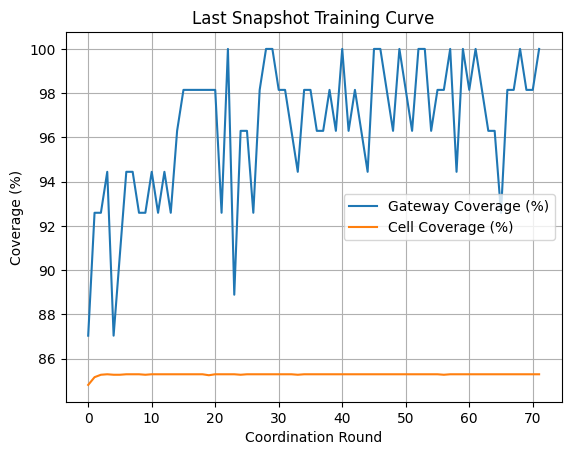

In [2]:
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN
from src.train_single import train_until_converged

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Model definition ===
hidden_dim = 64
model = None
optimizer = None

# === Loss weights ===
loss_weights = {
    'alpha': 3.0,
    'beta': 1.0,
    'gamma': 0.0,
    'delta': 4.0,
    'zeta': 0.0
}

# === Load top N snapshot files ===
top_n = 10
snapshot_files = sorted(os.listdir(folder_path))[:top_n]

# === Train iteratively ===
for idx, file in enumerate(snapshot_files):
    print(f"\n📦 Training on snapshot {idx+1}/{top_n}: {file}")
    
    # === Load and build graph ===
    satellites, gateways, cells = load_all_data(
        folder_path, cell_file, gateway_file, snapshot_filename=file
    )
    data = build_hetero_graph(satellites, gateways, cells)

    # === Normalize features ===
    data['sat'].x = normalize(data['sat'].x)
    data['gateway'].x = normalize(data['gateway'].x)
    data['cell'].x = normalize(data['cell'].x)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # === Auxiliary inputs ===
    visibility_matrix = torch.zeros((num_sats, num_gws))
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        visibility_matrix[src, dst] = 1

    cell_visibility_matrix = torch.zeros((num_sats, num_cells))
    for gw, cell in data['gateway', 'serves', 'cell'].edge_index.t():
        for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
            if dst == gw:
                cell_visibility_matrix[src, cell] = 1

    cell_demands = data['cell'].x[:, -1].unsqueeze(1)

    aux_inputs = {
        'visibility_matrix': visibility_matrix,
        'cell_visibility_matrix': cell_visibility_matrix,
        'cell_demands': cell_demands
    }

    # === Initialize or reuse model ===
    if model is None:
        model = SatGatewayGNN(hidden_dim, num_gateways=num_gws, num_cells=num_cells)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    # === Train on current snapshot ===
    model, history = train_until_converged(
        model=model,
        data=data,
        optimizer=optimizer,
        aux_inputs=aux_inputs,
        loss_weights=loss_weights,
        epochs=100,
        patience=10
    )

# === Save final trained model ===
torch.save(model.state_dict(), "trained_sat_gateway_model_multi.pt")
print("\n✅ Model saved as 'trained_sat_gateway_model_multi.pt'")

# === Optional Plot (last snapshot's history) ===
plt.plot([x * 100 for x in history['gateway_coverage']], label='Gateway Coverage (%)')
plt.plot([x * 100 for x in history['cell_coverage']], label='Cell Coverage (%)')
plt.xlabel('Coordination Round')
plt.ylabel('Coverage (%)')
plt.title('Last Snapshot Training Curve')
plt.legend()
plt.grid(True)
plt.show()



📦 Training on snapshot 1/10: file_data_00_00_00.csv
Epoch 001 | Loss: 2.8711 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 002 | Loss: 2.8470 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 003 | Loss: 2.8222 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 004 | Loss: 2.7963 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 005 | Loss: 2.7687 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 006 | Loss: 2.7388 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 007 | Loss: 2.7058 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 008 | Loss: 2.6691 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 009 | Loss: 2.6277 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 010 | Loss: 2.5811 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 011 | Loss: 2.5284 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 012 | Loss: 2.4689 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 013 | Loss: 2.4063 | GW-Coverage: 1.85% | Cell-Coverage: 99.52%
Epoch 014 | Loss: 2.3408 | GW-Coverag

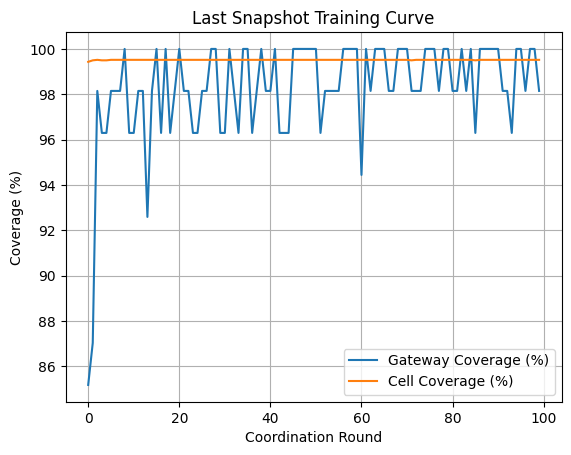

In [ ]:
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN
from src.train_single import train_until_converged

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Model definition ===
hidden_dim = 64
model = None
optimizer = None

# === Loss weights ===
loss_weights = {
    'alpha': 3.0,   # Gateway coverage
    'beta': 1.0,    # Satellite-GW assignment
    'gamma': 0.0,   # Demand fairness
    'delta': 4.0,   # Cell coverage
   # 'zeta': 0.0,    # Satellite capacity
    'spatial': 2.0  # Spatial contiguity 
}

# === Select every 10th snapshot file ===
all_files = sorted(os.listdir(folder_path))
snapshot_files = all_files[::10][:10]  # Pick 10 files: 0, 10, 20, ...

# === Train iteratively on selected snapshots ===
for idx, file in enumerate(snapshot_files):
    print(f"\n📦 Training on snapshot {idx+1}/{len(snapshot_files)}: {file}")
    
    # === Load and build graph ===
    satellites, gateways, cells = load_all_data(
        folder_path, cell_file, gateway_file, snapshot_filename=file
    )
    data = build_hetero_graph(satellites, gateways, cells)

    # === Normalize features ===
    data['sat'].x = normalize(data['sat'].x)
    data['gateway'].x = normalize(data['gateway'].x)
    data['cell'].x = normalize(data['cell'].x)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # === Auxiliary inputs ===
    visibility_matrix = torch.zeros((num_sats, num_gws))
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        visibility_matrix[src, dst] = 1

    cell_visibility_matrix = torch.zeros((num_sats, num_cells))
    for gw, cell in data['gateway', 'serves', 'cell'].edge_index.t():
        for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
            if dst == gw:
                cell_visibility_matrix[src, cell] = 1

    cell_demands = data['cell'].x[:, -1].unsqueeze(1)
    cell_coordinates = data['cell'].x[:, :2]  # Assuming lat-lon are first two features

    aux_inputs = {
        'visibility_matrix': visibility_matrix,
        'cell_visibility_matrix': cell_visibility_matrix,
        'cell_demands': cell_demands,
        'cell_coordinates': cell_coordinates
    }

    # === Initialize or reuse model ===
    if model is None:
        model = SatGatewayGNN(hidden_dim, num_gateways=num_gws, num_cells=num_cells)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    # === Train on current snapshot ===
    model, history = train_until_converged(
        model=model,
        data=data,
        optimizer=optimizer,
        aux_inputs=aux_inputs,
        loss_weights=loss_weights,
        epochs=100,
        patience=10
    )

# === Save final trained model ===
torch.save(model.state_dict(), "trained_sat_gateway_model_multi.pt")
print("\n✅ Model saved as 'trained_sat_gateway_model_multi.pt'")

# === Plot the training curve from the last snapshot ===
plt.plot([x * 100 for x in history['gateway_coverage']], label='Gateway Coverage (%)')
plt.plot([x * 100 for x in history['cell_coverage']], label='Cell Coverage (%)')
plt.xlabel('Coordination Round')
plt.ylabel('Coverage (%)')
plt.title('Last Snapshot Training Curve')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import os
import torch
import pandas as pd
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Select 11th file ===
snapshot_files = sorted(os.listdir(folder_path))
selected_file = snapshot_files[10]  # index 10 = 11th file
print(f"\n📄 Using snapshot file: {selected_file}")
snapshot_path = os.path.join(folder_path, selected_file)

# === Load and build graph ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=selected_file)
data = build_hetero_graph(satellites, gateways, cells)

# === Normalize ===
data['sat'].x = normalize(data['sat'].x)
data['gateway'].x = normalize(data['gateway'].x)
data['cell'].x = normalize(data['cell'].x)

# === Load model ===
num_gws = data['gateway'].num_nodes
num_cells = data['cell'].num_nodes
model = SatGatewayGNN(hidden_dim=64, num_gateways=num_gws, num_cells=num_cells)
model.load_state_dict(torch.load("trained_sat_gateway_model_multi.pt"))
model.eval()

# === Inference ===
with torch.no_grad():
    gw_probs, cell_probs = model(data)

# === Coverage Analysis ===
# Gateways
assigned_gateways = torch.argmax(gw_probs, dim=1).tolist()
covered_gateways = set(assigned_gateways)
all_gateways = set(range(num_gws))
uncovered_gateways = sorted(list(all_gateways - covered_gateways))

# Cells
threshold = 0.5
covered_cells = (cell_probs > threshold).any(dim=0).nonzero(as_tuple=True)[0].tolist()
all_cells = set(range(num_cells))
uncovered_cells = sorted(list(all_cells - set(covered_cells)))

# === Save Results ===
pd.DataFrame({'uncovered_gateway_id': uncovered_gateways}).to_csv("uncovered_gateways_snapshot11.csv", index=False)
pd.DataFrame({'uncovered_cell_id': uncovered_cells}).to_csv("uncovered_cells_snapshot11.csv", index=False)

# === Print Summary ===
print(f"\n✅ Snapshot tested: {selected_file}")
print(f"Uncovered Gateways: {len(uncovered_gateways)} / {num_gws}")
print(f"Uncovered Cells: {len(uncovered_cells)} / {num_cells}")



📄 Using snapshot file: file_data_00_03_20.csv

✅ Snapshot tested: file_data_00_03_20.csv
Uncovered Gateways: 17 / 54
Uncovered Cells: 110 / 4569


Another trial - more emphasis on spatial contigity


 Training on snapshot 1/5: file_data_00_00_00.csv
Epoch 001 | Loss: 50.3827 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 002 | Loss: 50.0366 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 003 | Loss: 49.6571 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 004 | Loss: 49.2081 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 005 | Loss: 48.6664 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 006 | Loss: 48.0125 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 007 | Loss: 47.2304 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 008 | Loss: 46.3039 | GW-Coverage: 0.00% | Cell-Coverage: 99.52%
Epoch 009 | Loss: 45.2138 | GW-Coverage: 1.85% | Cell-Coverage: 99.52%
Epoch 010 | Loss: 43.9486 | GW-Coverage: 1.85% | Cell-Coverage: 99.52%
Epoch 011 | Loss: 42.4918 | GW-Coverage: 3.70% | Cell-Coverage: 99.52%
Epoch 012 | Loss: 40.8346 | GW-Coverage: 3.70% | Cell-Coverage: 99.52%
Epoch 013 | Loss: 38.9662 | GW-Coverage: 5.56% | Cell-Coverage: 99.52%
Epoch 014 | Loss: 36.8850 

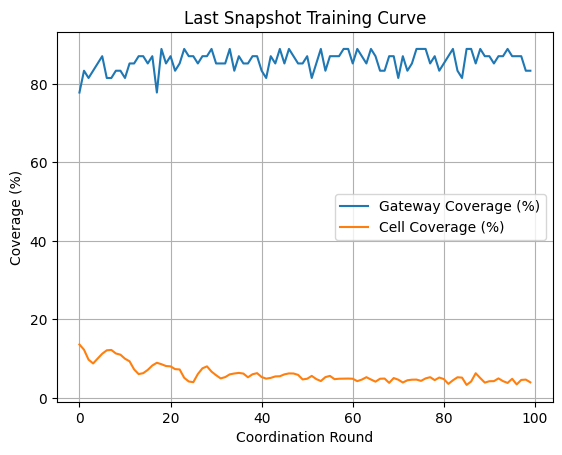

In [1]:
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN
from src.train_single import train_until_converged

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Model definition ===
hidden_dim = 64
model = None
optimizer = None

# === Loss weights ===
loss_weights = {
    'alpha': 3.0,   # Gateway coverage
    'beta': 1.0,    # Satellite-GW assignment
    'gamma': 0.0,   # Demand fairness
    'delta': 4.0,   # Cell coverage
   # 'zeta': 0.0,    # Satellite capacity
    'spatial': 1.5  # Spatial contiguity 
}

# === Select every 10th snapshot file ===
all_files = sorted(os.listdir(folder_path))
snapshot_files = all_files[::10][:5]  # Pick 10 files: 0, 10, 20, ...

# === Train iteratively on selected snapshots ===
for idx, file in enumerate(snapshot_files):
    print(f"\n Training on snapshot {idx+1}/{len(snapshot_files)}: {file}")
    
    # === Load and build graph ===
    satellites, gateways, cells = load_all_data(
        folder_path, cell_file, gateway_file, snapshot_filename=file
    )
    data = build_hetero_graph(satellites, gateways, cells)

    # === Normalize features ===
    data['sat'].x = normalize(data['sat'].x)
    data['gateway'].x = normalize(data['gateway'].x)
    data['cell'].x = normalize(data['cell'].x)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # === Auxiliary inputs ===
    visibility_matrix = torch.zeros((num_sats, num_gws))
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        visibility_matrix[src, dst] = 1

    cell_visibility_matrix = torch.zeros((num_sats, num_cells))
    for gw, cell in data['gateway', 'serves', 'cell'].edge_index.t():
        for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
            if dst == gw:
                cell_visibility_matrix[src, cell] = 1

    cell_demands = data['cell'].x[:, -1].unsqueeze(1)
    cell_coordinates = data['cell'].x[:, :2]  # Assuming lat-lon are first two features

    aux_inputs = {
        'visibility_matrix': visibility_matrix,
        'cell_visibility_matrix': cell_visibility_matrix,
        'cell_demands': cell_demands,
        'cell_coordinates': cell_coordinates
    }

    # === Initialize or reuse model ===
    if model is None:
        model = SatGatewayGNN(hidden_dim, num_gateways=num_gws, num_cells=num_cells)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    # === Train on current snapshot ===
    model, history = train_until_converged(
        model=model,
        data=data,
        optimizer=optimizer,
        aux_inputs=aux_inputs,
        loss_weights=loss_weights,
        epochs=100,
        patience=10
    )

# === Save final trained model ===
torch.save(model.state_dict(), "trained_sat_gateway_model_multi_1.pt")
print("\n Model saved as 'trained_sat_gateway_model_multi_1.pt'")

# === Plot the training curve from the last snapshot ===
plt.plot([x * 100 for x in history['gateway_coverage']], label='Gateway Coverage (%)')
plt.plot([x * 100 for x in history['cell_coverage']], label='Cell Coverage (%)')
plt.xlabel('Coordination Round')
plt.ylabel('Coverage (%)')
plt.title('Last Snapshot Training Curve')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
# === inference_predict.py ===
import os
import torch
import pandas as pd
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Select 11th snapshot file ===
snapshot_files = sorted(os.listdir(folder_path))
selected_file = snapshot_files[10]
snapshot_id = "_".join(os.path.splitext(selected_file)[0].split("_")[-3:])
print(f"\n📄 Using snapshot file: {selected_file}")

# === Load graph ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=selected_file)
data = build_hetero_graph(satellites, gateways, cells)

# === Normalize ===
data['sat'].x = normalize(data['sat'].x)
data['gateway'].x = normalize(data['gateway'].x)
data['cell'].x = normalize(data['cell'].x)

# === Load trained model ===
num_gws = data['gateway'].num_nodes
num_cells = data['cell'].num_nodes
model = SatGatewayGNN(hidden_dim=64, num_gateways=num_gws, num_cells=num_cells)
model.load_state_dict(torch.load("trained_sat_gateway_model_multi_1.pt"))
model.eval()

# === Inference ===
with torch.no_grad():
    gw_probs, cell_probs = model(data)

# === Save Results ===
threshold = 0.5
sat_ids = [s['sat_id'] for s in satellites]
lats = [s['latitude'] for s in satellites]
lngs = [s['longitude'] for s in satellites]
alts = [s['altitude'] for s in satellites]
predicted_gateways = torch.argmax(gw_probs, dim=1).tolist()
predicted_cells = (cell_probs > threshold).int()
predicted_cell_indices = [row.nonzero(as_tuple=True)[0].tolist() for row in predicted_cells]

prediction_df = pd.DataFrame({
    'sat_id': sat_ids,
    'latitude': lats,
    'longitude': lngs,
    'altitude': alts,
    'predicted_gateway': predicted_gateways,
    'predicted_cells': predicted_cell_indices
})

csv_path = f"satellite_to_cells_mapping_{snapshot_id}.csv"
prediction_df.to_csv(csv_path, index=False)
print(f"✅ Saved: {csv_path}")



📄 Using snapshot file: file_data_00_03_20.csv
✅ Saved: satellite_to_cells_mapping_00_03_20.csv


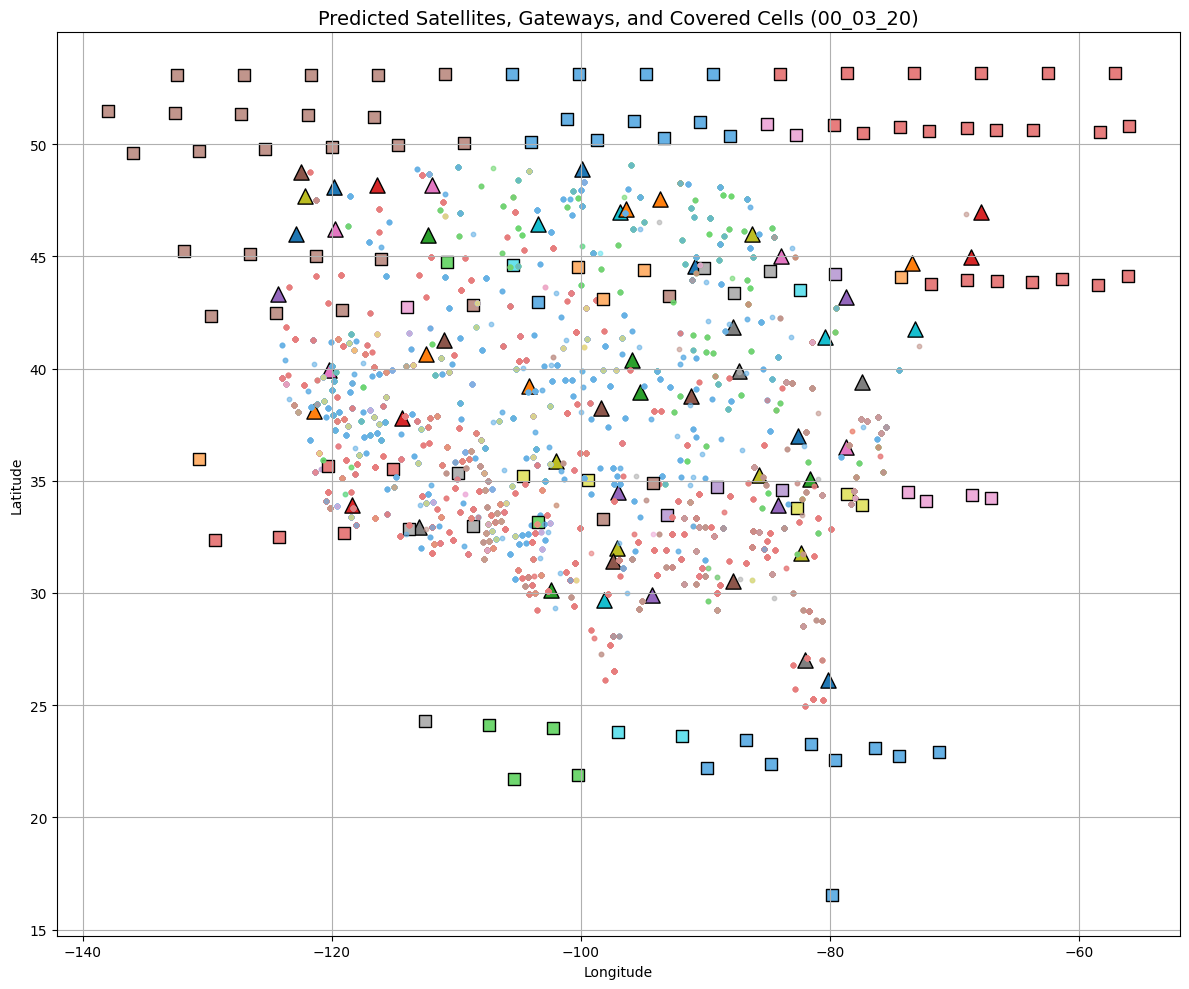

✅ Map saved: map_predicted_satellites_coverage_00_03_20.png


In [3]:
# === plot_prediction_map.py ===
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from ast import literal_eval

# === File info ===
snapshot_id = "00_03_20"
mapping_file = f"satellite_to_cells_mapping_{snapshot_id}.csv"

cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv", index_col="cell_id")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv")
mapping_df = pd.read_csv(mapping_file)

# === Parse list ===
mapping_df['predicted_cells'] = mapping_df['predicted_cells'].apply(
    lambda x: list(map(int, literal_eval(x))) if isinstance(x, str) else []
)

# === Color Map ===
NUM_GATEWAYS = 54
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)
gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

def lighten_color(color, amount=0.5):
    import colorsys
    try: c = mcolors.cnames[color]
    except: c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)

# === Plot ===
plt.figure(figsize=(12, 10))

# Plot gateways
for _, row in gw_df.iterrows():
    gw_id = int(row['gw_id'])
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'),
                edgecolor='black', s=120)

# Plot satellites and cells
MAX_CELLS_PER_SAT = 300
for _, row in mapping_df.iterrows():
    gw = row['predicted_gateway']
    color = lighten_color(gateway_color_map.get(gw, 'gray'), 0.4)

    # Satellite marker
    plt.scatter(row['longitude'], row['latitude'], marker='s', c=[color], edgecolor='black', s=80)

    # Cells
    cells = row['predicted_cells']
    if len(cells) > MAX_CELLS_PER_SAT:
        cells = np.random.choice(cells, MAX_CELLS_PER_SAT, replace=False)

    cell_subset = cells_df.loc[cells].dropna()
    plt.scatter(cell_subset['longitude'], cell_subset['latitude'], color=color, s=10, alpha=0.6)

# === Finalize ===
plt.title(f"Predicted Satellites, Gateways, and Covered Cells ({snapshot_id})", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()

map_path = f"map_predicted_satellites_coverage_{snapshot_id}.png"
plt.savefig(map_path, dpi=300)
plt.show()
print(f"✅ Map saved: {map_path}")


In [5]:
import os
import torch
import pandas as pd
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Select snapshot ===
snapshot_files = sorted(os.listdir(folder_path))
selected_file = snapshot_files[10]  # file index 10 = 11th snapshot
snapshot_id = "_".join(os.path.splitext(selected_file)[0].split("_")[-3:])
print(f"\n📄 Using snapshot file: {selected_file}")

# === Load and build graph ===
satellites, gateways, cells = load_all_data(
    folder_path, cell_file, gateway_file, snapshot_filename=selected_file
)
data = build_hetero_graph(satellites, gateways, cells)

# === Normalize features ===
data['sat'].x = normalize(data['sat'].x)
data['gateway'].x = normalize(data['gateway'].x)
data['cell'].x = normalize(data['cell'].x)

# === Load trained model ===
num_gws = data['gateway'].num_nodes
num_cells = data['cell'].num_nodes

model = SatGatewayGNN(hidden_dim=64, num_gateways=num_gws, num_cells=num_cells)
model.load_state_dict(torch.load("trained_sat_gateway_model_multi_1.pt"))  # << updated model
model.eval()

# === Inference ===
with torch.no_grad():
    gw_probs, cell_probs = model(data)

# === Coverage Analysis ===
assigned_gateways = torch.argmax(gw_probs, dim=1).tolist()
covered_gateways = set(assigned_gateways)
all_gateways = set(range(num_gws))
uncovered_gateways = sorted(list(all_gateways - covered_gateways))

threshold = 0.5
covered_cells = (cell_probs > threshold).any(dim=0).nonzero(as_tuple=True)[0].tolist()
all_cells = set(range(num_cells))
uncovered_cells = sorted(list(all_cells - set(covered_cells)))

# === Save results ===
gw_out_path = f"uncovered_gateways_{snapshot_id}.csv"
cell_out_path = f"uncovered_cells_{snapshot_id}.csv"

pd.DataFrame({'uncovered_gateway_id': uncovered_gateways}).to_csv(gw_out_path, index=False)
pd.DataFrame({'uncovered_cell_id': uncovered_cells}).to_csv(cell_out_path, index=False)

# === Print summary ===
print(f"\n✅ Snapshot tested: {selected_file}")
print(f"Uncovered Gateways: {len(uncovered_gateways)} / {num_gws}")
print(f"Uncovered Cells: {len(uncovered_cells)} / {num_cells}")
print(f"📁 Saved: {gw_out_path}, {cell_out_path}")



📄 Using snapshot file: file_data_00_03_20.csv

✅ Snapshot tested: file_data_00_03_20.csv
Uncovered Gateways: 26 / 54
Uncovered Cells: 3908 / 4569
📁 Saved: uncovered_gateways_00_03_20.csv, uncovered_cells_00_03_20.csv


Maps

In [4]:
import os
import torch
import pandas as pd
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Select 11th file ===
snapshot_files = sorted(os.listdir(folder_path))
selected_file = snapshot_files[20]
snapshot_id = "_".join(os.path.splitext(selected_file)[0].split("_")[-3:])

print(f"\n📄 Using snapshot file: {selected_file}")

# === Load + build graph ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=selected_file)
data = build_hetero_graph(satellites, gateways, cells)

# Normalize node features
data['sat'].x = normalize(data['sat'].x)
data['gateway'].x = normalize(data['gateway'].x)
data['cell'].x = normalize(data['cell'].x)

# === Load trained model ===
num_gws = data['gateway'].num_nodes
num_cells = data['cell'].num_nodes
model = SatGatewayGNN(hidden_dim=64, num_gateways=num_gws, num_cells=num_cells)
model.load_state_dict(torch.load("trained_sat_gateway_model_multi.pt"))
model.eval()

# === Inference ===
with torch.no_grad():
    gw_probs, cell_probs = model(data)

# === Save Mapping CSV ===
threshold = 0.5
sat_ids = [s['sat_id'] for s in satellites]
lats = [s['latitude'] for s in satellites]
lngs = [s['longitude'] for s in satellites]
alts = [s['altitude'] for s in satellites]
predicted_gateways = torch.argmax(gw_probs, dim=1).tolist()
predicted_cells = (cell_probs > threshold).to(torch.int)
predicted_cell_indices = [row.nonzero(as_tuple=True)[0].tolist() for row in predicted_cells]

prediction_df = pd.DataFrame({
    'sat_id': sat_ids,
    'latitude': lats,
    'longitude': lngs,
    'altitude': alts,
    'predicted_gateway': predicted_gateways,
    'predicted_cells': predicted_cell_indices
})

csv_path = f"satellite_to_cells_mapping_{snapshot_id}.csv"
prediction_df.to_csv(csv_path, index=False)
print(f"✅ Saved: {csv_path}")



📄 Using snapshot file: file_data_00_06_40.csv
✅ Saved: satellite_to_cells_mapping_00_06_40.csv


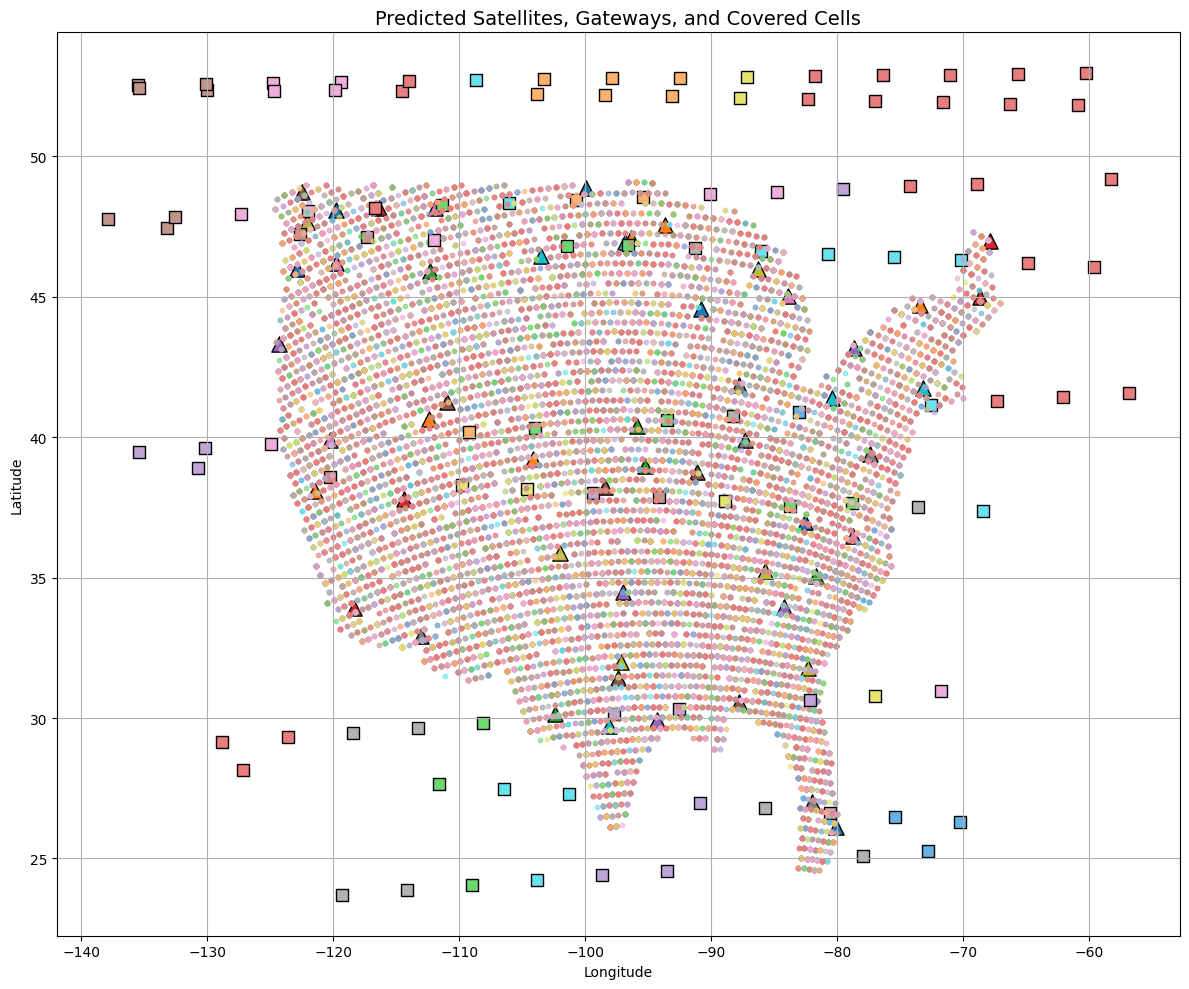

✅ Map saved: map_predicted_satellites_coverage_00_06_40.png


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from ast import literal_eval

# === File paths ===
snapshot_id = "00_06_40"
mapping_file = f"satellite_to_cells_mapping_{snapshot_id}.csv"
cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv", index_col="cell_id")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv")
mapping_df = pd.read_csv(mapping_file)

# === Parse cell list ===
mapping_df['predicted_cells'] = mapping_df['predicted_cells'].apply(
    lambda x: list(map(int, literal_eval(x))) if isinstance(x, str) else [])

# === Color Setup ===
NUM_GATEWAYS = 54
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)
gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

def lighten_color(color, amount=0.5):
    import colorsys
    try: c = mcolors.cnames[color]
    except: c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)

# === Prepare for plotting ===
plt.figure(figsize=(12, 10))

# Plot gateways (triangles)
for _, row in gw_df.iterrows():
    gw_id = int(row['gw_id'])
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), edgecolor='black', s=120)

# Limit cells per satellite to avoid plotting overload
MAX_CELLS_PER_SAT = 300

# Group by satellite
for _, row in mapping_df.iterrows():
    gateway = row['predicted_gateway']
    color = lighten_color(gateway_color_map.get(gateway, 'gray'), 0.4)

    # Satellite square
    plt.scatter(row['longitude'], row['latitude'], marker='s', c=[color], edgecolor='black', s=80)

    # Cells (dots) — batched plotting
    cells = row['predicted_cells']
    if len(cells) > MAX_CELLS_PER_SAT:
        cells = np.random.choice(cells, MAX_CELLS_PER_SAT, replace=False)

    cell_subset = cells_df.loc[cells].dropna()
    plt.scatter(cell_subset['longitude'], cell_subset['latitude'], color=color, s=10, alpha=0.6)

# === Final touches ===
plt.title("Predicted Satellites, Gateways, and Covered Cells", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
map_file = f"map_predicted_satellites_coverage_{snapshot_id}.png"
plt.savefig(map_file, dpi=300)
plt.show()
print(f"✅ Map saved: {map_file}")


In [7]:
import os
import torch
import pandas as pd
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Select snapshot #20 ===
snapshot_files = sorted(os.listdir(folder_path))
selected_file = snapshot_files[20]
snapshot_id = "_".join(os.path.splitext(selected_file)[0].split("_")[-3:])
print(f"\n📄 Using snapshot file: {selected_file}")

# === Load and build graph ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=selected_file)
data = build_hetero_graph(satellites, gateways, cells)

# === Normalize features ===
data['sat'].x = normalize(data['sat'].x)
data['gateway'].x = normalize(data['gateway'].x)
data['cell'].x = normalize(data['cell'].x)

# === Load trained model ===
num_gws = data['gateway'].num_nodes
num_cells = data['cell'].num_nodes

model = SatGatewayGNN(hidden_dim=64, num_gateways=num_gws, num_cells=num_cells)
model.load_state_dict(torch.load("trained_sat_gateway_model_multi.pt"))
model.eval()

# === Inference ===
with torch.no_grad():
    gw_probs, cell_probs = model(data)

# === Predict assignments ===
threshold = 0.5
sat_ids = [s['sat_id'] for s in satellites]
lats = [s['latitude'] for s in satellites]
lngs = [s['longitude'] for s in satellites]
alts = [s['altitude'] for s in satellites]

predicted_gateways = torch.argmax(gw_probs, dim=1).tolist()
predicted_cells = (cell_probs > threshold).to(torch.int)
predicted_cell_indices = [row.nonzero(as_tuple=True)[0].tolist() for row in predicted_cells]

# === Save full prediction map ===
prediction_df = pd.DataFrame({
    'sat_id': sat_ids,
    'latitude': lats,
    'longitude': lngs,
    'altitude': alts,
    'predicted_gateway': predicted_gateways,
    'predicted_cells': predicted_cell_indices
})
csv_path = f"satellite_to_cells_mapping_{snapshot_id}.csv"
prediction_df.to_csv(csv_path, index=False)
print(f"✅ Mapping saved: {csv_path}")

# === Coverage Analysis ===
assigned_gateways = set(predicted_gateways)
all_gateways = set(range(num_gws))
uncovered_gateways = sorted(list(all_gateways - assigned_gateways))

covered_cells = (cell_probs > threshold).any(dim=0).nonzero(as_tuple=True)[0].tolist()
all_cells = set(range(num_cells))
uncovered_cells = sorted(list(all_cells - set(covered_cells)))

# === Save uncovered results ===
gw_out_path = f"uncovered_gateways_{snapshot_id}.csv"
cell_out_path = f"uncovered_cells_{snapshot_id}.csv"

pd.DataFrame({'uncovered_gateway_id': uncovered_gateways}).to_csv(gw_out_path, index=False)
pd.DataFrame({'uncovered_cell_id': uncovered_cells}).to_csv(cell_out_path, index=False)

# === Print summary ===
print(f"\n✅ Snapshot tested: {selected_file}")
print(f"Uncovered Gateways: {len(uncovered_gateways)} / {num_gws}")
print(f"Uncovered Cells: {len(uncovered_cells)} / {num_cells}")
print(f"📁 Saved: {gw_out_path}, {cell_out_path}")



📄 Using snapshot file: file_data_00_06_40.csv
✅ Mapping saved: satellite_to_cells_mapping_00_06_40.csv

✅ Snapshot tested: file_data_00_06_40.csv
Uncovered Gateways: 13 / 54
Uncovered Cells: 114 / 4569
📁 Saved: uncovered_gateways_00_06_40.csv, uncovered_cells_00_06_40.csv


⚠️ Couldn't plot uncovered gateways: [Errno 2] No such file or directory: 'uncovered_gateways_snapshot20.csv'
⚠️ Couldn't plot uncovered cells: [Errno 2] No such file or directory: 'uncovered_cells_snapshot20.csv'


C:\Users\aruna\AppData\Local\Temp\ipykernel_2020\3806681015.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize=8)


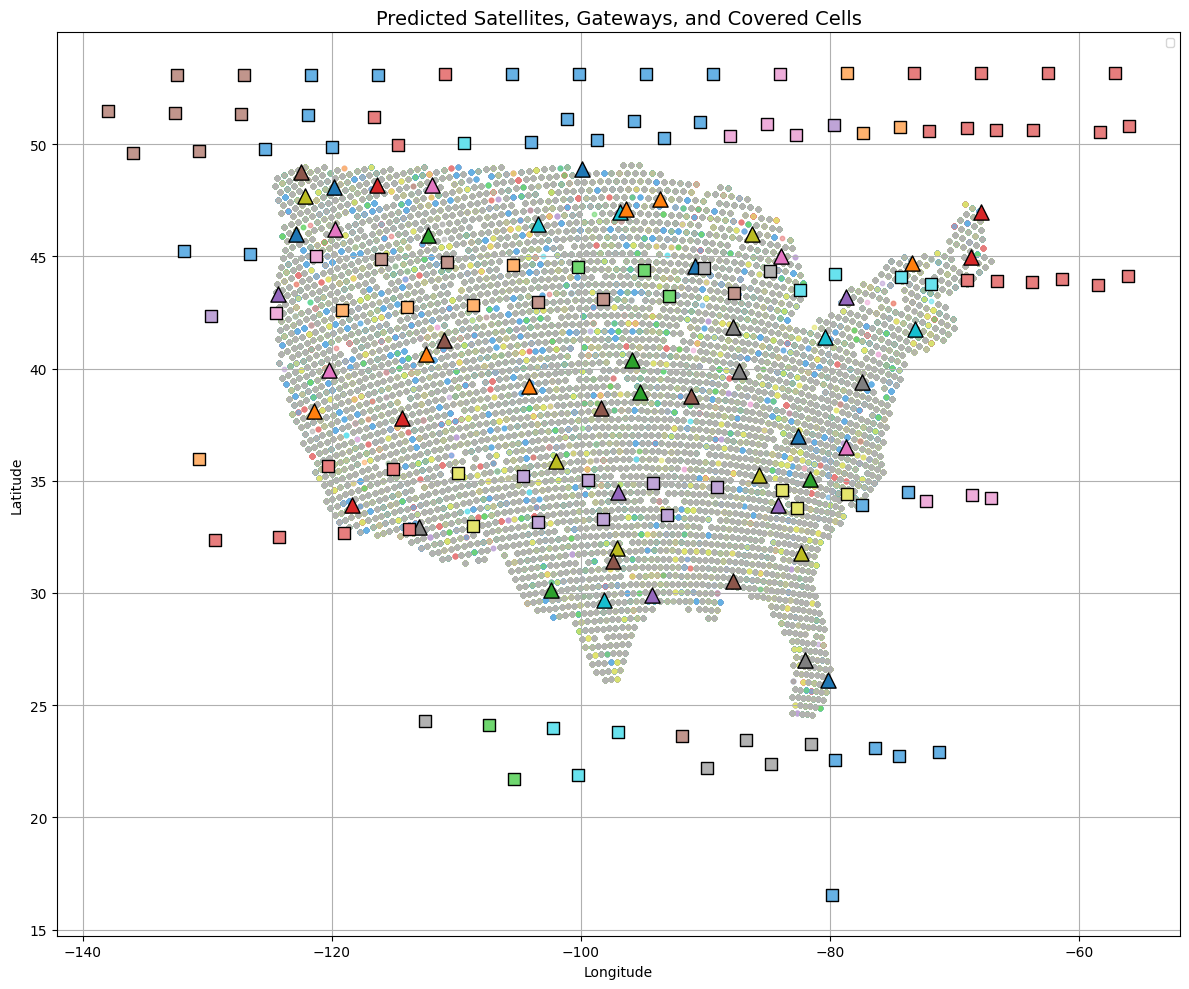

✅ Saved: map_predicted_satellites_coverage_00_03_20.png


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from ast import literal_eval
from collections import defaultdict

# === File identifiers ===
snapshot_id = "00_03_20"  # Based on the actual filename: file_data_00_03_20.csv

# === Load Data ===
mapping_file = f"satellite_to_cells_mapping_{snapshot_id}.csv"
mapping_df = pd.read_csv(mapping_file)
cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv", index_col="cell_id")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv")

# === Parse list-like column ===
mapping_df['predicted_cells'] = mapping_df['predicted_cells'].apply(
    lambda x: list(map(int, literal_eval(x))) if isinstance(x, str) else [])

# === Color Setup ===
NUM_GATEWAYS = 54
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)
gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

def lighten_color(color, amount=0.5):
    import colorsys
    try: c = mcolors.cnames[color]
    except: c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)

# === Start Plot ===
plt.figure(figsize=(12, 10))

# --- Gateways (Triangle) ---
for _, row in gw_df.iterrows():
    gw_id = int(row['gw_id'])
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'),
                edgecolor='black', s=120, zorder=2)

# --- Satellites (Square) ---
for _, row in mapping_df.iterrows():
    gw_id = row['predicted_gateway']
    color = lighten_color(gateway_color_map.get(gw_id, 'gray'), 0.4)
    plt.scatter(row['longitude'], row['latitude'], marker='s',
                c=[color], edgecolor='black', s=80, zorder=3)

# --- Predicted Cells (Optimized Batch) ---
cell_coords_by_color = defaultdict(lambda: {'lat': [], 'lng': []})

for _, row in mapping_df.iterrows():
    color = lighten_color(gateway_color_map.get(row['predicted_gateway'], 'gray'), 0.4)
    for cell_id in row['predicted_cells']:
        if cell_id in cells_df.index:
            lng, lat = cells_df.loc[cell_id, ['longitude', 'latitude']]
            cell_coords_by_color[color]['lng'].append(lng)
            cell_coords_by_color[color]['lat'].append(lat)

for color, coords in cell_coords_by_color.items():
    plt.scatter(coords['lng'], coords['lat'], color=color, s=10, alpha=0.6, zorder=1)

# --- Highlight Uncovered Gateways ---
try:
    gw_missing_df = pd.read_csv(f"uncovered_gateways_snapshot{snapshot_id[-2:]}.csv")
    for gw_id in gw_missing_df['uncovered_gateway_id']:
        row = gw_df[gw_df['gw_id'] == gw_id]
        if not row.empty:
            x, y = row.iloc[0][['longitude', 'latitude']]
            plt.scatter(x, y, marker='^', color='black', s=200,
                        edgecolors='white', linewidths=1.5, zorder=5)
            plt.text(x, y + 0.15, f"GW {gw_id}", color='black',
                     fontsize=8, ha='center', zorder=6)
except Exception as e:
    print(f"⚠️ Couldn't plot uncovered gateways: {e}")

# --- Highlight Uncovered Cells ---
try:
    cell_missing_df = pd.read_csv(f"uncovered_cells_snapshot{snapshot_id[-2:]}.csv")
    missing_ids = cell_missing_df['uncovered_cell_id'].tolist()
    missing_cells_df = cells_df.loc[cells_df.index.intersection(missing_ids)]
    plt.scatter(missing_cells_df['longitude'], missing_cells_df['latitude'],
                color='black', s=20, marker='o', alpha=0.8,
                label='Uncovered Cells', zorder=4)
except Exception as e:
    print(f"⚠️ Couldn't plot uncovered cells: {e}")

# --- Final Touches ---
plt.title("Predicted Satellites, Gateways, and Covered Cells", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()

# Save
map_file = f"map_predicted_satellites_coverage_{snapshot_id}.png"
plt.savefig(map_file, dpi=300)
plt.show()

print(f"✅ Saved: {map_file}")


In [ ]:
import os
import torch
from src.train import train
from src.evaluation import evaluate
from src.graph_builder import build_graph_from_snapshot
from src.data_loader import load_all_data
from src.model import SatelliteCoverageGNN

# === Paths ===
FOLDER = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
CELL_FILE = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
GW_FILE = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Load Data ===
print("Loading data...")
snapshots, gateways = load_all_data(FOLDER, CELL_FILE, GW_FILE, limit=10)

# === Build Graphs ===
print("Building graphs...")
graphs = []
cells_per_snapshot = []

for timestamp, snapshot in snapshots.items():
    df = snapshot['raw_df']
    cells = snapshot['cells']  # includes demand
    graph = build_graph_from_snapshot(df, cells, gateways)
    graph['timestep'] = timestamp
    graphs.append(graph)
    cells_per_snapshot.append(cells)

print(f"Built {len(graphs)} graphs")

# === Train/Test Split ===
train_graphs = graphs[:8]
train_cells = cells_per_snapshot[:8]

test_graphs = graphs[8:]
test_cells = cells_per_snapshot[8:]

# === Init Model ===
model = SatelliteCoverageGNN(
    sat_feat_dim=57,     # 3 pos + 54 gateway vis
    cell_feat_dim=3,     # lat, lon, demand
    hidden_dim=64,
    num_gateways=54
)

# === Train ===
print("Training model...")
train(model, train_graphs, train_cells, device, epochs=5, lr=1e-3)

# === Evaluate ===
if test_graphs:
    print("Evaluating...")
    results = evaluate(model, test_graphs, device)
    print("Evaluation Results:")
    for k, v in results.items():
        print(f"{k.capitalize()}: {v:.4f}")
else:
    print("No test graphs available.")


Loading data...
Found 4320 CSV files matching pattern in folder: C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data
Building graphs...
Built 10 graphs
Training model...


KeyboardInterrupt: 